In [ ]:
import utils
import quantus
import torch
%matplotlib inline


In [ ]:
# !pip install pytorch_grad_cam

In [31]:
import cv2
import numpy as np

def resize_image(image_path, target_size=(224, 224)):

    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img_rgb = img[..., ::-1]
    img_resized = cv2.resize(img_rgb, target_size)
    img_normalized = img_resized / 255.0
    if img_normalized.shape[2] != 3:
        raise ValueError("Image does not have 3 channels")
    return img_normalized


In [33]:
import torchvision

model = torchvision.models.vgg16(pretrained=True); 
model.eval()
print("Done")

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done


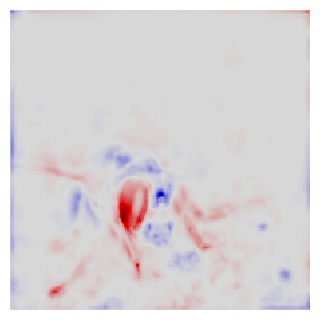

In [147]:
"""
Only LRP for single image 
"""
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from PIL import Image


def heatmap(R):

    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    return my_cmap,b

os.makedirs('heatmap_images',exist_ok=True)

mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)


image_path = 'fly.jpg'
processed_image = resize_image(image_path)
img = np.array(cv2.imread(image_path))[..., ::-1] / 255.0
img = cv2.resize(img, (224, 224))
X = (torch.FloatTensor(img[np.newaxis].transpose([0,3,1,2])*1) - mean) / std
epsilon = 0.25
gamma = 0.25
delta = 1e-10  #For non zero in denominator
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)
A = [X] + [None] * L
for l in range(L):
    A[l + 1] = layers[l].forward(A[l])
scores = np.array(A[-1].data.view(-1))
ind = np.argsort(-scores)
T = torch.FloatTensor((1.0 * (np.arange(1000) == np.argmax(scores)).reshape([1, 1000, 1, 1])))
R = [None] * L + [(A[-1] * T).data] 

for l in range(1, L)[::-1]:
    A[l] = A[l].data.requires_grad_(True)
    if isinstance(layers[l], torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)
    if isinstance(layers[l], torch.nn.Conv2d) or isinstance(layers[l], torch.nn.AvgPool2d):
      
      
        #  Modified LRP
        if l <= 18:                 rho = lambda p: p  + gamma*p.clamp(min=0)  ;                                        incr = lambda z: z ; apply_eps =False
        elif 18 <= l <= 32:         rho = lambda p: p   ;               incr = lambda z: z ; apply_eps = False
        else                :        rho = lambda p: p  ;                                        incr = lambda z: z ; apply_eps =False

        # Original LRP
        # if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9  
        # if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        # if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l], rho).forward(A[l]))  
        if apply_eps:
            s = (R[l + 1] / (z + delta + epsilon)  ).data  
        else:
            s = (R[l + 1] / (z + delta )  ).data  
        (z * s).sum().backward()
        c = A[l].grad  
        R[l] = (A[l] * c).data  
        
    else:
        R[l] = R[l + 1]
    
for i, l in enumerate([1]):

    A[0] = (A[0].data).requires_grad_(True)

    lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
    hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

    z = layers[0].forward(A[0])                                   # step 1 (a)
    z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
    z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
    s = (R[1]/ (z + delta ) ).data                                                      # step 2
    (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
    R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4


    my_cmap, b = heatmap(np.array(R[0][0]).sum(axis=0))
    plt.figure(figsize=(3, 3))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')
    plt.imshow(np.array(R[0][0]).sum(axis=0), cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    # plt.savefig(f'heatmap_images/heatmap_{gamma}.png')
    plt.show()
    plt.close()



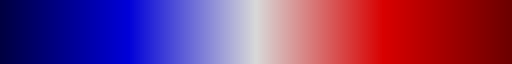

In [73]:
my_cmap

Top Prediction:
Class ID: 308
Class Name: ['n02190166', 'fly']
Probability: 0.9919


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


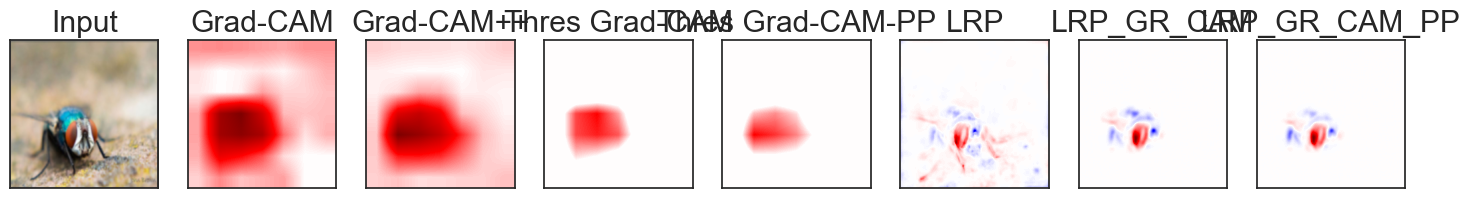

In [148]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
import json


# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Preprocess the image and add a batch dimension
input_tensor = X.to(device)  # Assuming X is already in the correct shape

# Make the prediction
with torch.no_grad():
    output = model(input_tensor)

# Apply softmax to get probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

with open('imagenet_class_index.json') as f:
    labels = json.load(f)

# Get the top prediction
top_prob, top_catid = torch.max(probabilities, dim=0)

# Get the class name for the top prediction
top_prediction_index = top_catid.item()
top_prediction_prob = top_prob.item()
top_prediction_name = labels.get(str(top_prediction_index), "Unknown class")

# Print the top prediction details
print(f"Top Prediction:")
print(f"Class ID: {top_prediction_index}")
print(f"Class Name: {top_prediction_name}")
print(f"Probability: {top_prediction_prob:.4f}")


target_index = torch.argmax(probabilities).item()
# Initialize GradCAM and GradCAM++
grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])

# Apply GradCAM and GradCAM++
grayscale_grad_cam = grad_cam(input_tensor=input_tensor)
grayscale_grad_cam_pp = grad_cam_pp(input_tensor=input_tensor)



"""   
Compute R pending

"""
# Process LRP attributions
attributions_lrp_np = R[0].cpu().detach().numpy()
attributions_lrp_np = np.transpose(attributions_lrp_np, (0, 2, 3, 1))
attributions_lrp_np = np.average(attributions_lrp_np, axis=3)
attributions_lrp_np = (attributions_lrp_np.T / np.max(attributions_lrp_np, axis=(1, 2)).T).T

# Threshold GradCAM results
grayscale_grad_cam_thr = np.copy(grayscale_grad_cam)
grayscale_grad_cam_thr = grayscale_grad_cam_thr - 0.5
grayscale_grad_cam_thr = np.clip(grayscale_grad_cam_thr, 0, 1)
product_grad_cam = attributions_lrp_np * grayscale_grad_cam_thr
product_grad_cam = (product_grad_cam.T / np.max(product_grad_cam, axis=(1, 2)).T).T


# Threshold GradCAMPP results
grayscale_grad_cam_pp_thr = np.copy(grayscale_grad_cam_pp)
grayscale_grad_cam_pp_thr = grayscale_grad_cam_pp_thr - 0.5
grayscale_grad_cam_pp_thr = np.clip(grayscale_grad_cam_pp_thr, 0, 1)
product_grad_cam_pp = attributions_lrp_np * grayscale_grad_cam_pp_thr
product_grad_cam_pp = (product_grad_cam_pp.T / np.max(product_grad_cam_pp, axis=(1, 2)).T).T

# Smooth the GradCAM result
smoothed_grad_cam = np.zeros(product_grad_cam.shape)
for i in range(0, product_grad_cam.shape[0]):
    smoothed_grad_cam[i] = cv2.GaussianBlur(product_grad_cam[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam[i] = smoothed_grad_cam[i] / np.max(smoothed_grad_cam[i])

# Smooth the GradCAM result
smoothed_grad_cam_pp = np.zeros(product_grad_cam_pp.shape)
for i in range(0, product_grad_cam_pp.shape[0]):
    smoothed_grad_cam_pp[i] = cv2.GaussianBlur(product_grad_cam_pp[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam_pp[i] = smoothed_grad_cam_pp[i] / np.max(smoothed_grad_cam_pp[i])

# Plot results
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(18, 4.5))
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(input_tensor[0].cpu().detach().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text("Input")
axes[1].imshow(grayscale_grad_cam[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[1].title.set_text("Grad-CAM")
axes[2].imshow(grayscale_grad_cam_pp[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[2].title.set_text("Grad-CAM++")
axes[3].imshow(grayscale_grad_cam_thr[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[3].title.set_text("Thres Grad-CAM")
axes[4].imshow(grayscale_grad_cam_pp_thr[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[4].title.set_text("Thres Grad-CAM-PP")
axes[5].imshow(attributions_lrp_np[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[5].title.set_text("LRP")
axes[6].imshow(smoothed_grad_cam[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[6].title.set_text("LRP_GR_CAM")
axes[7].imshow(smoothed_grad_cam_pp[0], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[7].title.set_text("LRP_GR_CAM_PP")
for i in range(0, 8):
    axes[i].axis("on")
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])

plt.savefig('example.png', bbox_inches='tight')
plt.show()

In [ ]:
# image_files = [os.path.join('heatmap_images', x) for x in os.listdir('heatmap_images')]
# images = [Image.open(img) for img in image_files]
# images[0].save('LRP.gif',
#                save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)

In [149]:
# Code for Batches
# Dataset 
path_to_files = "imagenet_dataset"

# Load test data and make loaders.
x_batch = torch.load(f'{path_to_files}/x_batch.pt')
y_batch = torch.load(f'{path_to_files}/y_batch.pt')
s_batch = torch.load(f'{path_to_files}/s_batch.pt')
s_batch = s_batch.unsqueeze(dim=1)

In [157]:
import torch
import numpy as np

def LRP(model, input, target):
    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
    std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
    
    # Normalize the batch
    X = (input - mean) / std

    epsilon = 0.25
    gamma = 0.25
    
    delta = 1e-10
    layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
    L = len(layers)

    batch_size = X.size(0)
    relevance_maps = []

    for i in range(batch_size):
        # Process each image in the batch separately
        A = [X[i:i+1]] + [None] * L
        
        # Forward pass
        for l in range(L):
            A[l + 1] = layers[l].forward(A[l])

        # Use the provided target class index from target
        target_class = target[i]

        T = torch.zeros_like(A[-1])
        T[0, target_class] = 1.0

        R = [None] * L + [(A[-1] * T).data]

        # Backward pass
        # for l in range(L-1, -1, -1):
        #     A[l] = A[l].data.requires_grad_(True)

        #     if isinstance(layers[l], torch.nn.MaxPool2d):
        #         layers[l] = torch.nn.AvgPool2d(kernel_size=2)

        #     if isinstance(layers[l], (torch.nn.Conv2d, torch.nn.AvgPool2d)):
        #         # LRP rules
        #         if l <= 16:
        #             rho = lambda p: p + 0.25 * p.clamp(min=0)
        #             incr = lambda z: z + 1e-9
        #         elif 17 <= l <= 30:
        #             rho = lambda p: p
        #             incr = lambda z: z + 1e-9 + 0.25 * ((z**2).mean()**0.5).data
        #         else:
        #             rho = lambda p: p
        #             incr = lambda z: z + 1e-9

        #         z = incr(utils.newlayer(layers[l], rho).forward(A[l]))
        #         s = (R[l + 1] / z).data
        #         (z * s).sum().backward()
        #         c = A[l].grad
        #         R[l] = (A[l] * c).data
        #     else:
        #         R[l] = R[l + 1]

        # # Relevance for the input layer
        # A[0] = A[0].data.requires_grad_(True)

        # lb = (A[0].data * 0 + (0 - mean) / std).requires_grad_(True)
        # hb = (A[0].data * 0 + (1 - mean) / std).requires_grad_(True)

        # z = layers[0].forward(A[0]) + 1e-9
        # z -= utils.newlayer(layers[0], lambda p: p.clamp(min=0)).forward(lb)
        # z -= utils.newlayer(layers[0], lambda p: p.clamp(max=0)).forward(hb)
        # s = (R[1] / z).data
        # (z * s).sum().backward()

        # c, cp, cm = A[0].grad, lb.grad, hb.grad
        # R[0] = (A[0] * c + lb * cp + hb * cm).data


        for l in range(1, L)[::-1]:
            A[l] = A[l].data.requires_grad_(True)
            if isinstance(layers[l], torch.nn.MaxPool2d):
                layers[l] = torch.nn.AvgPool2d(2)
            if isinstance(layers[l], torch.nn.Conv2d) or isinstance(layers[l], torch.nn.AvgPool2d):
            
            
                #  Modified LRP
                if l <= 18:                 rho = lambda p: p  + gamma*p.clamp(min=0)  ;                                        incr = lambda z: z ; apply_eps =False
                elif 18 <= l <= 32:         rho = lambda p: p   ;               incr = lambda z: z ; apply_eps = True
                else                :        rho = lambda p: p  ;                                        incr = lambda z: z ; apply_eps =False

                # Original LRP
                # if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9  
                # if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
                # if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

                z = incr(utils.newlayer(layers[l], rho).forward(A[l]))  
                if apply_eps:
                    s = (R[l + 1] / (z + delta + epsilon)  ).data  
                else:
                    s = (R[l + 1] / (z + delta )  ).data  
                (z * s).sum().backward()
                c = A[l].grad  
                R[l] = (A[l] * c).data  
                
            else:
                R[l] = R[l + 1]
            
        for i, l in enumerate([1]):

            A[0] = (A[0].data).requires_grad_(True)

            lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
            hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

            z = layers[0].forward(A[0])                                   # step 1 (a)
            z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
            z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
            s = (R[1]/ (z + delta ) ).data                                                      # step 2
            (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
            R[0] = (A[0]*c+lb*cp+hb*cm).data                   
                # Collect the relevance map for the current image
        relevance_maps.append(R[0])
    
    # Stack all relevance maps into a single tensor
    relevance_maps = torch.cat(relevance_maps, dim=0)
    
    return relevance_maps

In [151]:
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus


grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])


x = x_batch
y = y_batch

grayscale_grad_cam = grad_cam(input_tensor=x )
grayscale_grad_cam_pp = grad_cam_pp(input_tensor=x )
attributions_lrp = LRP(model, input = x ,target=y )



attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
attributions_lrp_np = np.transpose(attributions_lrp_np, (0,2,3,1))
attributions_lrp_np = np.average(attributions_lrp_np, axis=3)
attributions_lrp_np = (attributions_lrp_np.T/np.max(attributions_lrp_np, axis=(1,2)).T).T


# Threshold GradCAM results
grayscale_grad_cam_thr = np.copy(grayscale_grad_cam)
grayscale_grad_cam_thr = grayscale_grad_cam_thr - 0.2
grayscale_grad_cam_thr = np.clip(grayscale_grad_cam_thr, 0, 1)
product_grad_cam = attributions_lrp_np * grayscale_grad_cam_thr
product_grad_cam = (product_grad_cam.T / np.max(product_grad_cam, axis=(1, 2)).T).T


# Threshold GradCAMPP results
grayscale_grad_cam_pp_thr = np.copy(grayscale_grad_cam_pp)
grayscale_grad_cam_pp_thr = grayscale_grad_cam_pp_thr - 0.2
grayscale_grad_cam_pp_thr = np.clip(grayscale_grad_cam_pp_thr, 0, 1)
product_grad_cam_pp = attributions_lrp_np * grayscale_grad_cam_pp_thr
product_grad_cam_pp = (product_grad_cam_pp.T / np.max(product_grad_cam_pp, axis=(1, 2)).T).T

# Smooth the GradCAM result
smoothed_grad_cam = np.zeros(product_grad_cam.shape)
for i in range(0, product_grad_cam.shape[0]):
    smoothed_grad_cam[i] = cv2.GaussianBlur(product_grad_cam[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam[i] = smoothed_grad_cam[i] / np.max(smoothed_grad_cam[i])

# Smooth the GradCAM result
smoothed_grad_cam_pp = np.zeros(product_grad_cam_pp.shape)
for i in range(0, product_grad_cam_pp.shape[0]):
    smoothed_grad_cam_pp[i] = cv2.GaussianBlur(product_grad_cam_pp[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam_pp[i] = smoothed_grad_cam_pp[i] / np.max(smoothed_grad_cam_pp[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


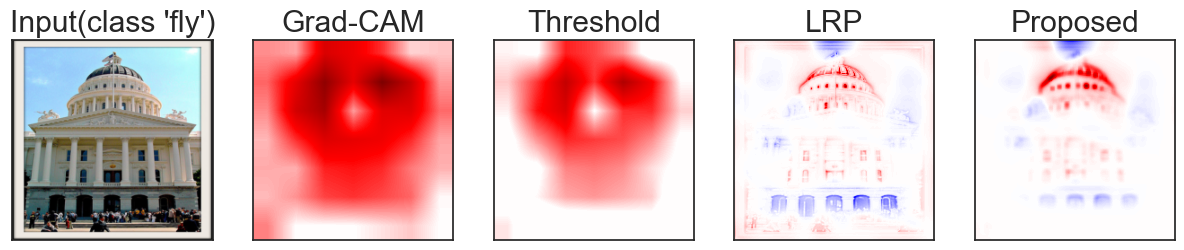

In [152]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4.5))
idx = 6
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch[idx].cpu().detach().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text("Input(class 'fly')")
axes[1].imshow(grayscale_grad_cam[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[1].title.set_text("Grad-CAM")
axes[2].imshow(grayscale_grad_cam_thr[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[2].title.set_text("Threshold")
axes[3].imshow(attributions_lrp_np[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[3].title.set_text("LRP")
axes[4].imshow(smoothed_grad_cam[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[4].title.set_text("Proposed")
for i in range(0, 5):
    axes[i].axis("on")
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
plt.show()

In [153]:

# from my_captum.metrics import infidelity

# noise = torch.tensor(np.random.normal(0, 0.003, (x.size()[0]*10, 3, 224, 224))).float()

# def perturb_fn(inputs):
#    print(inputs.size() , noise.size())
#    return noise, inputs - noise

# infid = infidelity(model, perturb_fn, x, attributions_lrp, normalize=True, target=y)




torch.Size([170, 3, 224, 224]) torch.Size([170, 3, 224, 224])



KeyboardInterrupt



In [158]:
import numpy as np
def explainer_wrapper(model, inputs, targets, **kwargs) -> np.ndarray:
    """Wrapper for explainer functions."""

    grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
    grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])


    inputs = torch.tensor(inputs)
    targets = torch.tensor(targets)


    if kwargs["method"] == "GradCAM":
        grayscale_grad_cam = grad_cam(input_tensor=inputs )
        grayscale_grad_cam = (grayscale_grad_cam.T / np.max(grayscale_grad_cam, axis=(1,2)).T).T
        grayscale_grad_cam = np.expand_dims(grayscale_grad_cam, axis=(1))
        return grayscale_grad_cam
    if kwargs["method"] == "GradCAMPP":
        grayscale_grad_cam_pp = grad_cam_pp(input_tensor=inputs )
        grayscale_grad_cam_pp = (grayscale_grad_cam_pp.T / np.max(grayscale_grad_cam_pp, axis=(1,2)).T).T
        grayscale_grad_cam_pp = np.expand_dims(grayscale_grad_cam_pp, axis=(1))
        return grayscale_grad_cam_pp
    elif kwargs["method"] == "LRP":
        attributions_lrp =  LRP(model, input = inputs ,target=targets )
        attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
        attributions_lrp_np = np.average(attributions_lrp_np, axis=1)
        attributions_lrp_np = (attributions_lrp_np.T/np.max(attributions_lrp_np, axis=(1,2)).T).T
        attributions_lrp_np = np.expand_dims(attributions_lrp_np, axis=(1))    
        return attributions_lrp_np
    elif kwargs["method"] == "Proposed_method":

        grayscale_grad_cam_pp = grad_cam_pp(input_tensor=inputs )
        grayscale_grad_cam_pp_thr = np.copy(grayscale_grad_cam_pp)
        grayscale_grad_cam_pp_thr = grayscale_grad_cam_pp_thr - 0.2
        grayscale_grad_cam_pp_thr = np.clip(grayscale_grad_cam_pp_thr, 0, 1)
        
        
        attributions_lrp = LRP(model, input = inputs ,target=targets )
        attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
        attributions_lrp_np = np.average(attributions_lrp_np, axis=1)
        product = attributions_lrp_np*grayscale_grad_cam_pp_thr
        for i in range(0, product.shape[0]):
            product[i] = cv2.GaussianBlur(product[i],(5,5),cv2.BORDER_DEFAULT)
        product = (product.T / np.max(product, axis=(1,2)).T).T
        
        product = np.expand_dims(product, axis=(1))
        

        return product
    else:
        raise ValueError("Pick an explanation function that exists.")
    



In [159]:
xai_methods = ['Proposed_method', 'LRP','GradCAM','GradCAMPP' ]

grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])
metrics = {
    "Robustness": quantus.AvgSensitivity(
        nr_samples=10,
        lower_bound=0.2,
        norm_numerator=quantus.norm_func.fro_norm,
        norm_denominator=quantus.norm_func.fro_norm,
        perturb_func=quantus.perturb_func.uniform_noise,
        similarity_func=quantus.similarity_func.difference,
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Faithfulness": quantus.FaithfulnessCorrelation(
        nr_runs=10,
        subset_size=224,
        perturb_baseline="uniform",
        perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
        similarity_func=quantus.similarity_func.correlation_pearson,
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Localisation": quantus.RelevanceRankAccuracy(
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Complexity": quantus.Sparseness(
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Randomisation": quantus.RandomLogit(
        num_classes=1000,
        similarity_func=quantus.similarity_func.ssim,
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
}

In [160]:
model.eval()
results = {method : {} for method in xai_methods}

for method in xai_methods:
    for metric, metric_func in metrics.items():
        print(f"Evaluating {metric} of {method} method.")
        scores = metric_func(
            model=model,
            x_batch=x_batch.cpu().detach().numpy(),
            y_batch=y_batch.cpu().detach().numpy(),
            a_batch=None,
            s_batch=s_batch.cpu().detach().numpy(),
            explain_func=explainer_wrapper,
            explain_func_kwargs={
                "method": method,
            },
        )
        results[method][metric] = scores

Evaluating Robustness of Proposed_method method.
Evaluating Faithfulness of Proposed_method method.
Evaluating Localisation of Proposed_method method.
Evaluating Complexity of Proposed_method method.
Evaluating Randomisation of Proposed_method method.
Evaluating Robustness of LRP method.


In [ ]:
results

{'Proposed_method': {'Robustness': [0.5327670869776626],
  'Faithfulness': [-0.10531436996071349],
  'Localisation': [0.5938937709535537],
  'Complexity': [0.8707956554356532],
  'Randomisation': [0.8405010391754977]},
 'LRP': {'Robustness': [0.5095487422510689],
  'Faithfulness': [-0.1007002520764204],
  'Localisation': [0.5732350965661517],
  'Complexity': [0.7383549318905823],
  'Randomisation': [0.7632850349410231]},
 'GradCAM': {'Robustness': [0.30176458367530035],
  'Faithfulness': [0.11292768101139834],
  'Localisation': [0.6929768505634578],
  'Complexity': [0.4154548936966865],
  'Randomisation': [1.0000000218154579]},
 'GradCAMPP': {'Robustness': [0.21578561492702542],
  'Faithfulness': [0.034818498647545645],
  'Localisation': [0.7458860212511745],
  'Complexity': [0.42190169930844174],
  'Randomisation': [0.999999991116155]}}

In [ ]:
# Postprocessing of scores: to get how the different explanation methods rank across criteria.
import numpy as np
import pandas as pd
results_agg = {}
for method in xai_methods:
    results_agg[method] = {}
    for metric, metric_func in metrics.items():
        results_agg[method][metric] = np.mean(results[method][metric])

df = pd.DataFrame.from_dict(results_agg)
df = df.T.abs()

# Take inverse ranking for Robustness, since lower is better.
df_normalised = df.loc[:, df.columns != 'Robustness'].apply(lambda x: x / x.max())
df_normalised["Robustness"] = df["Robustness"].min()/df["Robustness"].values
df_normalised_rank = df_normalised.rank()
df_normalised_rank

,Faithfulness,Localisation,Complexity,Randomisation,Robustness
Proposed_method,3.0,2.0,4.0,2.0,1.0
LRP,2.0,1.0,3.0,1.0,2.0
GradCAM,4.0,3.0,1.0,4.0,3.0
GradCAMPP,1.0,4.0,2.0,3.0,4.0


In [ ]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [ ]:
def radar_factory(num_vars, frame='circle'):

    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default."""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default."""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, angles=None):
            self.set_thetagrids(angles=np.degrees(theta), labels=labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped."""
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)

                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# Plotting configs.
sns.set(font_scale=1.8)
plt.style.use('seaborn-v0_8-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True

include_titles = True
include_legend = True

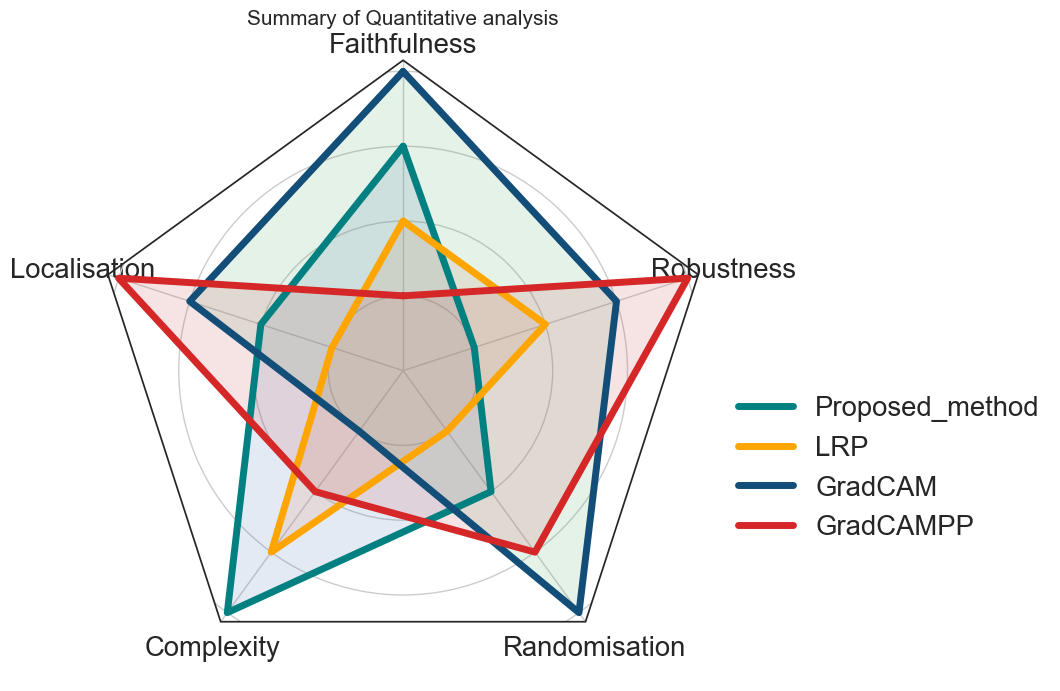

In [ ]:
# Make spyder graph!
colours_order = ["#008080", "#FFA500", "#124E78", "#d62728"]
data = [df_normalised_rank.columns.values, (df_normalised_rank.to_numpy())]
theta = radar_factory(len(data[0]), frame='polygon')
spoke_labels = data.pop(0)

fig, ax = plt.subplots(figsize=(11, 11), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)
for i, (d, method) in enumerate(zip(data[0], xai_methods)):
    line = ax.plot(theta, d, label=method, color=colours_order[i], linewidth=5.0)
    ax.fill(theta, d, alpha=0.15)

# Set lables.
if include_titles:
    ax.set_varlabels(labels=['Faithfulness', 'Localisation   ', '\nComplexity', '\nRandomisation', '   Robustness'])
else:
    ax.set_varlabels(labels=[]) 

ax.set_rgrids(np.arange(0, df_normalised_rank.values.max() + 0.5), labels=[]) 

# Set a title.
ax.set_title("Summary of Quantitative analysis",  position=(0.5, 1.1), ha='center', fontsize=15)

# Put a legend to the right of the current axis.
if include_legend:
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('my_figure.png', bbox_inches='tight')